**<center><h1>Aging factor Notebook</h1></center>**

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import FenicsATL as FATL
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.manifold import TSNE

from multiprocessing import Process


Loading BokehJS ...

# **I. DATA INITIALIZATION**

I.1 FENICS 01

In [3]:
FENICS_to_analyse = [15,14,13,12,11,10,9,8,7,6,5,4] #11 removed
filter_id = [15,14,13,12,10,9,8,7,6,5,4]
filter_id_slow = [15,14,13,12,10,9,8,6,5,4] #7 removed bad integrator

FENICS = FATL.FenicsData_read('/AtlasDisk/home2/sisaid/data/FENICS_data.json')



# FENICS = FATL.FilterbyUniqueChannels(FENICS)

FENICS = FENICS[FENICS.Board.specialTests ==  'None']

Fast = FATL.FenicsTestTable(FENICS,'fast')
Slow = FATL.FenicsTestTable(FENICS,'slow')

FastFeaturesToDrop = [("NoiseHG","Mean"),("NoiseHG","Mu"),
                      ("NoiseHGIG1","Mean"),("NoiseHGIG1","Mu"),
                      ("NoiseHGIG2","Mean"),("NoiseHGIG2","Mu"),
                      ("NoiseHGIG6","Mean"),("NoiseHGIG6","Mu"),
                      ("NoiseLG","Mean"),("NoiseLG","Mu"),
                      ("NoiseLGIG1","Mean"),("NoiseLGIG1","Mu"),
                      ("NoiseLGIG2","Mean"),("NoiseLGIG2","Mu"),
                      ("NoiseLGIG6","Mean"),("NoiseLGIG6","Mu")]

for feature in FastFeaturesToDrop:
    Fast = Fast.drop(feature, axis=1) 

slow_index = Slow.index
Slow.dropna(subset=[('Gain3','Linearity','SlopeLin'),('Gain4','Linearity','SlopeLin'),('Gain5','Linearity','SlopeLin')], inplace=True)
Slow.dropna(inplace=True,axis=1)
Fast.drop(index=slow_index.difference(Slow.index), inplace=True)
FENICS.drop(index=slow_index.difference(Slow.index), inplace=True)

FastSlow = pd.concat([Slow, Fast], axis=1)
# Slow = FATL.Normalizer(Slow)
# Fast = FATL.Normalizer(Fast)


In [4]:
FENICS

Board                                                         \
       name version  id  code burnings burnTime        date   time   
0    FENICS       1  15  FDrb        1      193  2021-03-25  14:02   
14   FENICS       1  15  FDrb        5      891  2021-10-05  08:50   
15   FENICS       1  15  FDrb        5      891  2021-10-05  10:30   
16   FENICS       1  15  FDTR        2      361  2022-01-04  11:25   
17   FENICS       1  15  FDrb       14     2444  2021-12-15  11:36   
..      ...     ...  ..   ...      ...      ...         ...    ...   
664  FENICS       1   4   NDb       41     8219  2023-06-06  09:35   
665  FENICS       1   1   FDb        1      193  2021-03-25  14:02   
679  FENICS       1   1   FDb        5      891  2021-10-05  08:50   
680  FENICS       1   1   FDb        5      891  2021-10-05  10:30   
681  FENICS       1   1   FDb        6     1059  2021-10-12  12:15   

                          ...  \
    specialTests channel  ...   
0           None       0  ...   
14          None      11  ...   
15          None      11  ...   
16          None       0  ...   
17          None       0  ...   
..           ...     ...  ...   
664         None      10  ...   
665         None       6  ...   
679         None      10  ...   
680         None      10  ...   
681         None      10  ...   

                                            FastResult  \
                                               NoiseLG   
0    {'Mu': 97.73063897963084, 'Sigma': 1.078502766...   
14   {'Mu': 125.20885479650201, 'Sigma': 1.06547375...   
15   {'Mu': 125.17386911187909, 'Sigma': 1.06932731...   
16   {'Mu': 97.5667899170892, 'Sigma': 1.0630539223...   
17   {'Mu': 97.78201546493148, 'Sigma': 1.060466340...   
..                                                 ...   
664  {'Mu': 100.28157728961273, 'Sigma': 1.03805288...   
665  {'Mu': 101.11882474479363, 'Sigma': 1.08653869...   
679  {'Mu': 116.53436194708264, 'Sigma': 1.04509448...   
680  {'Mu': 116.69378382844607, 'Sigma': 1.04134275...   
681  {'Mu': 116.54060364696532, 'Sigma': 1.03508950...   

                                                        \
                                            NoiseLGIG1   
0    {'Mu': 97.71968858563208, 'Sigma': 1.062337795...   
14   {'Mu': 125.16436460745344, 'Sigma': 1.07825099...   
15   {'Mu': 125.16478064399445, 'Sigma': 1.07313199...   
16   {'Mu': 97.53213153288333, 'Sigma': 1.063044589...   
17   {'Mu': 97.76381126866572, 'Sigma': 1.062525107...   
..                                                 ...   
664  {'Mu': 100.34443479745838, 'Sigma': 1.04031741...   
665  {'Mu': 101.16694964424315, 'Sigma': 1.11446899...   
679  {'Mu': 116.48817270180528, 'Sigma': 1.05336924...   
680  {'Mu': 116.78618570700154, 'Sigma': 1.03548511...   
681  {'Mu': 116.54436694527965, 'Sigma': 1.05024201...   

                                                        \
                                            NoiseLGIG2   
0    {'Mu': 97.72812743018778, 'Sigma': 1.071447677...   
14   {'Mu': 125.21089976721827, 'Sigma': 1.06951339...   
15   {'Mu': 125.11645152552487, 'Sigma': 1.07085648...   
16   {'Mu': 97.51643438652245, 'Sigma': 1.061581194...   
17   {'Mu': 97.79895258247575, 'Sigma': 1.048304458...   
..                                                 ...   
664  {'Mu': 100.27166140356664, 'Sigma': 1.03929744...   
665  {'Mu': 101.01981926374837, 'Sigma': 1.10317316...   
679  {'Mu': 116.47058271952874, 'Sigma': 1.05245738...   
680  {'Mu': 116.78498416850381, 'Sigma': 1.05911969...   
681  {'Mu': 116.4618932579643, 'Sigma': 1.040382590...   

                                                        \
                                            NoiseLGIG6   
0    {'Mu': 97.75260598880364, 'Sigma': 1.067633028...   
14   {'Mu': 125.19552676715811, 'Sigma': 1.07398238...   
15   {'Mu': 125.12049403670136, 'Sigma': 1.06133584...   
16   {'Mu': 97.56358216950397, 'Sigma': 1.067097938...   
17   {'Mu': 97.82085217511325, 'Sigma': 1.058580640.

In [5]:
len(FENICS)

522

In [6]:
FENICS_to_analyse = [15,14,13,12,11,10,9,8,7,6,5,4] #11 removed
filter_id = [15,14,13,12,10,9,8,7,6,5,4]
filter_id_slow = [15,14,13,12,10,9,8,6,5,4] #7 removed bad integrator

FENICS = FATL.FenicsVers_filter(FATL.FenicsData_read('/AtlasDisk/home2/sisaid/data/FENICS_data.json'),
                                FENICS_to_analyse ,index=True)

# temp_allindex = []
# for id in FENICS_to_analyse :
#     temp_index = FENICS[FENICS.Board.id == id][FENICS.Board.channel == FENICS[FENICS.Board.id == id].Board.channel.value_counts().index[0]].index.tolist()
#     temp_allindex = temp_allindex + temp_index

# FENICS = FENICS.loc[temp_allindex]
FENICS = FENICS[FENICS.Board.specialTests ==  'None']

Fast = FATL.FenicsTestTable(FENICS,'fast')
Slow = FATL.FenicsTestTable(FENICS,'slow')

Slow.dropna(inplace=True,axis=1)

I.2 FENICS 02

In [7]:
FENICS2 = FATL.FenicsData_read('/AtlasDisk/home2/sisaid/data/FENICS2_data.json')

# FENICS2 = FENICS2[FENICS2.Board.burnTime.notna()]

# temp_allindex = []
# for id in FENICS2.Board.id.unique() :
#     temp_index = FENICS2[FENICS2.Board.id == id][FENICS2.Board.channel == FENICS2[FENICS2.Board.id == id].Board.channel.value_counts().index[0]].index.tolist()
#     temp_allindex = temp_allindex + temp_index
    
# FENICS2 = FENICS2.loc[temp_allindex]
FENICS2 = FENICS2[(FENICS2.Board.StatusFast != -1) | (FENICS2.Board.StatusSlow != -1)]

Fast2 = FATL.FenicsTestTable(FENICS2,'fast')
Slow2 = FATL.FenicsTestTable(FENICS2,'slow')


# Slow2 = FATL.Normalizer(Slow2)
# Fast2 = FATL.Normalizer(Fast2)

for feature in FastFeaturesToDrop:
    Fast2 = Fast2.drop(feature, axis=1) 

slow2_index = Slow2.index

Slow2.dropna(subset=[('Gain0','Linearity','SlopeLin'),('Gain1','Linearity','SlopeLin'),('Gain3','Linearity','SlopeLin'),('Gain4','Linearity','SlopeLin'),('Gain5','Linearity','SlopeLin'),
                     ('Gain0','Linearity','ConstLin'),('Gain1','Linearity','ConstLin'),('Gain3','Linearity','ConstLin'),('Gain4','Linearity','ConstLin'),('Gain5','Linearity','ConstLin'),], inplace=True)
Slow2.dropna(inplace=True,axis=1)
Fast2.drop(index=slow2_index.difference(Slow2.index), inplace=True)
FENICS2.drop(index=slow2_index.difference(Slow2.index), inplace=True)



FastSlow2 = pd.concat([Slow2, Fast2], axis=1)

I.3 FENICS 01 and FENICS 02

In [8]:
FENICS12 = FENICS.append(FENICS2,ignore_index=True)
Fast12 = Fast.append(Fast2,ignore_index=True)
Slow12 = Slow.append(Slow2,ignore_index=True)
Slow12.dropna(subset=[('Gain3','Linearity','SlopeLin'),('Gain4','Linearity','SlopeLin'),('Gain5','Linearity','SlopeLin')], inplace=True)
Slow12.dropna(inplace=True,axis=1)

FastSlow12 = pd.concat([Slow12, Fast12], axis=1)


In [9]:
FEN1_ids = [1,4,5,6,7,8,9,10,11,12,13,14,15]
FEN2_batch01_ids = [29,30,31,32,33,34,35,36,37,38,39,40]
FEN2_batch02_ids = [1041,1042,1043,1044,1045,1046,1047]
NIEL_ids = [101,102,103,104,105,111,112,114,115,121,122,123,124,125,131,132,133,134,135]
TID_ids = [106,107,108,109,110,116,117,118,119,120,126,127,128,129,130,136,137,138,139,140,1021,1022,1023,1024,1025]

FENICS12_fail = FENICS12.Board.id[(FENICS12.Board.StatusFast==0 ) | (FENICS12.Board.StatusSlow==0)]
FENICS2_fail = FENICS2.Board.id[(FENICS2.Board.StatusFast==0 ) | (FENICS2.Board.StatusSlow==0)]
FENICS_fail = FENICS.Board.id[(FENICS.Board.StatusFast==0 ) | (FENICS.Board.StatusSlow==0)]

AllFen12 = list(set(FENICS12.Board.id[(FENICS12.Board.StatusFast==0 ) | (FENICS12.Board.StatusSlow==0)])
                .union(set(FEN1_ids),
                       set(FEN2_batch01_ids),
                       set(FEN2_batch02_ids),
                       set(NIEL_ids),
                       set(TID_ids))
                )

AllFen2 = list(set(FENICS2.Board.id[(FENICS2.Board.StatusFast==0 ) | (FENICS2.Board.StatusSlow==0)])
               .union(
                set(FEN2_batch01_ids),
                set(FEN2_batch02_ids),
                set(NIEL_ids),
                set(TID_ids))
                )

AllFen = list(set(FENICS_fail).union(set(FEN1_ids)))

AllFen12LTT = list(set(FEN1_ids).union(set(FEN2_batch01_ids),set(FEN2_batch02_ids)))
AllFen2LTT = list(set(FEN2_batch01_ids).union(set(FEN2_batch02_ids)))

In [10]:
FENICS12_LTT = pd.DataFrame()
for id in AllFen12LTT :
    FENICS12_LTT = pd.concat([FENICS12_LTT,FENICS12.Board[FENICS12.Board.id == id]])

In [11]:
FENICS2_LTT = pd.DataFrame()
for id in AllFen12LTT :
    FENICS2_LTT = pd.concat([FENICS2_LTT,FENICS2.Board[FENICS2.Board.id == id]])

 Created folder at /users/divers/atlas/sisaid/home2/LatexPlots


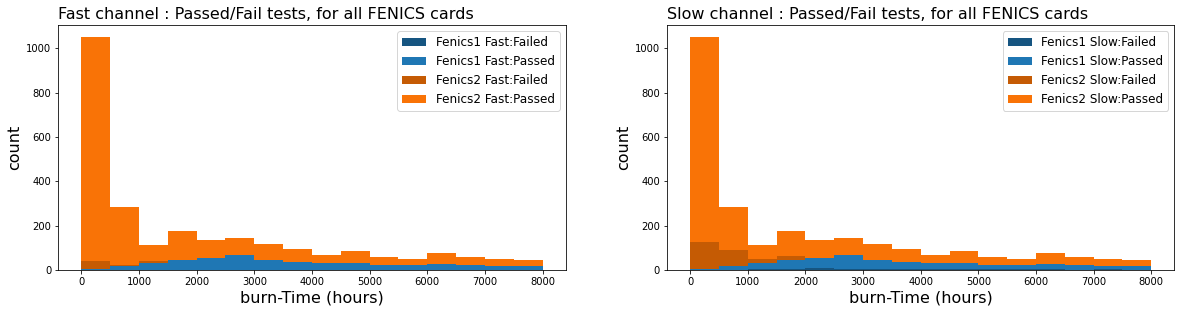

In [13]:
# Assuming you have two DataFrames named 'fenics1_df' and 'fenics2_df'
# containing 'burnTimes' and 'testStatus' columns
plt.figure(figsize=(20,11.25))
plt.subplots_adjust(wspace=0.2, hspace=0.5)
channels = {
            'Fast' : 'StatusFast',
            'Slow' : 'StatusSlow'
            }

for sub,channel in enumerate(channels):
    # Combine the test status of Fenics1 and Fenics2 into a single list for each burn time
    fenics1_failed = FENICS.Board.loc[FENICS.Board[channels[channel]] == 0, 'burnTime'].tolist()
    fenics1_passed = FENICS.Board.loc[FENICS.Board[channels[channel]] == 1, 'burnTime'].tolist()
    fenics2_failed = FENICS2.Board.loc[FENICS2.Board[channels[channel]] == 0, 'burnTime'].tolist()
    fenics2_passed = FENICS2.Board.loc[FENICS2.Board[channels[channel]] == 1, 'burnTime'].tolist()

    plt.subplot(2,2,sub+1)
    # Calculate the maximum burn time
    max_burn_time = max(
        max(fenics1_failed, default=0),
        max(fenics1_passed, default=0),
        max(fenics2_failed, default=0),
        max(fenics2_passed, default=0)
    )

    # Generate the histogram with four bars for each burn time
    plt.hist(
        [fenics1_failed, fenics1_passed, fenics2_failed, fenics2_passed],
        bins=np.arange(0, max_burn_time, 500),
        color=['#165581', '#1f77b4', '#c55b04', '#F97306'],
        label=['Fenics1 ' +channel+ ':Failed', 'Fenics1 ' +channel+ ':Passed', 'Fenics2 ' +channel+ ':Failed', 'Fenics2 ' +channel+ ':Passed'],
        alpha=1,
        histtype='bar',
        stacked=True
    )

    plt.legend(fontsize='large')
    plt.xlabel('burn-Time (hours)',fontsize=16)
    plt.ylabel('count',fontsize=16)
    plt.title(channel+' channel : Passed/Fail tests, for all FENICS cards',fontsize=16, loc='left')
FATL.checkFolderAt("/users/divers/atlas/sisaid/home2/LatexPlots")
plt.savefig('/users/divers/atlas/sisaid/home2/LatexPlots/all_fenics_fail-pass_histogram.svg')
plt.show()

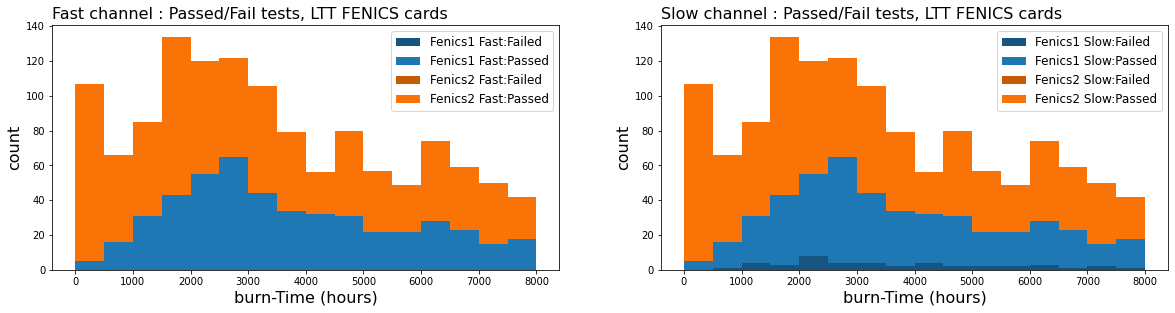

In [14]:
# Assuming you have two DataFrames named 'fenics1_df' and 'fenics2_df'
# containing 'burnTimes' and 'testStatus' columns
plt.figure(figsize=(20,11.25))
plt.subplots_adjust(wspace=0.2, hspace=0.5)
channels = {
            'Fast' : 'StatusFast',
            'Slow' : 'StatusSlow'
            }

for sub,channel in enumerate(channels):
    # Combine the test status of Fenics1 and Fenics2 into a single list for each burn time
    fenics1_failed = FENICS.Board.loc[FENICS.Board[channels[channel]] == 0, 'burnTime'].tolist()
    fenics1_passed = FENICS.Board.loc[FENICS.Board[channels[channel]] == 1, 'burnTime'].tolist()
    fenics2_failed = FENICS2_LTT.loc[FENICS2_LTT[channels[channel]] == 0, 'burnTime'].tolist()
    fenics2_passed = FENICS2_LTT.loc[FENICS2_LTT[channels[channel]] == 1, 'burnTime'].tolist()

    plt.subplot(2,2,sub+1)
    # Calculate the maximum burn time
    max_burn_time = max(
        max(fenics1_failed, default=0),
        max(fenics1_passed, default=0),
        max(fenics2_failed, default=0),
        max(fenics2_passed, default=0)
    )

    # Generate the histogram with four bars for each burn time
    plt.hist(
        [fenics1_failed, fenics1_passed, fenics2_failed, fenics2_passed],
        bins=np.arange(0, max_burn_time, 500),
        color=['#165581', '#1f77b4', '#c55b04', '#F97306'],
        label=['Fenics1 ' +channel+ ':Failed', 'Fenics1 ' +channel+ ':Passed', 'Fenics2 ' +channel+ ':Failed', 'Fenics2 ' +channel+ ':Passed'],
        alpha=1,
        histtype='bar',
        stacked=True
    )

    plt.legend(fontsize='large')
    plt.xlabel('burn-Time (hours)',fontsize=16)
    plt.ylabel('count',fontsize=16)
    plt.title(channel+' channel : Passed/Fail tests, LTT FENICS cards',fontsize=16, loc='left')
plt.savefig('/users/divers/atlas/sisaid/home2/LatexPlots/LTT_fenics_fail-pass_histogram.svg')
plt.show()

<center><h1>Acceleration factor calculation

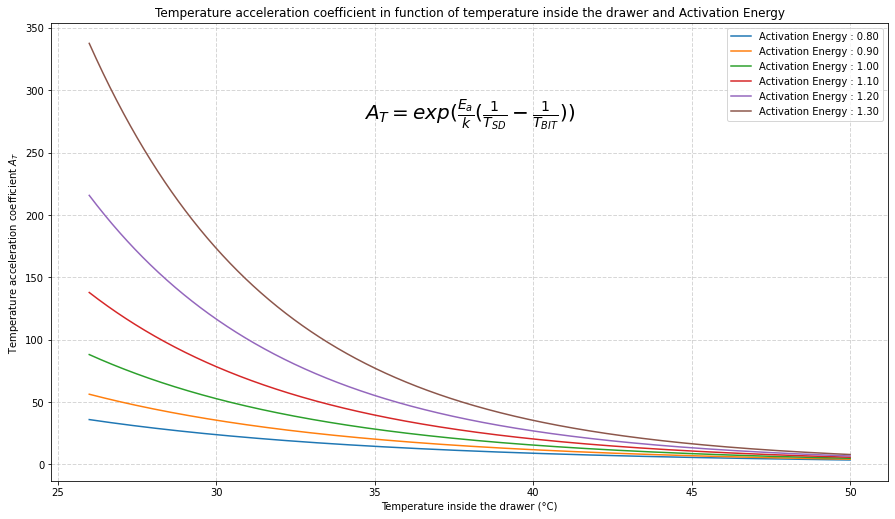

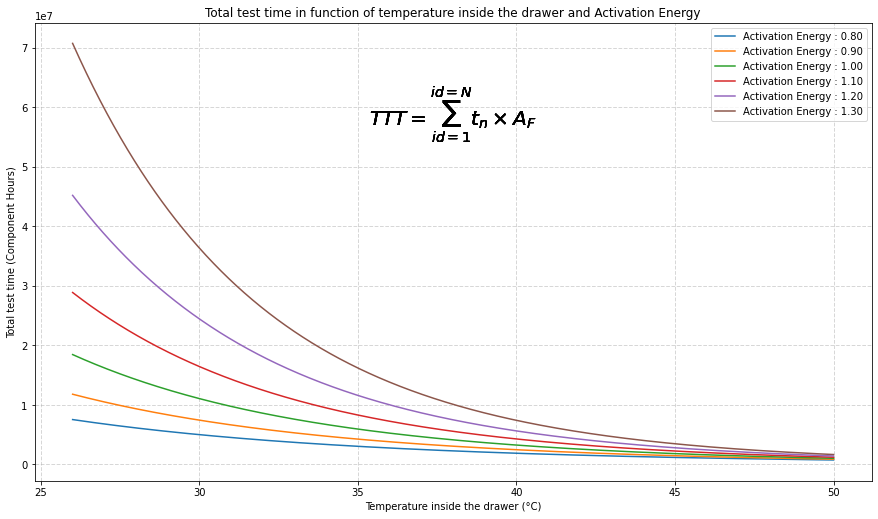

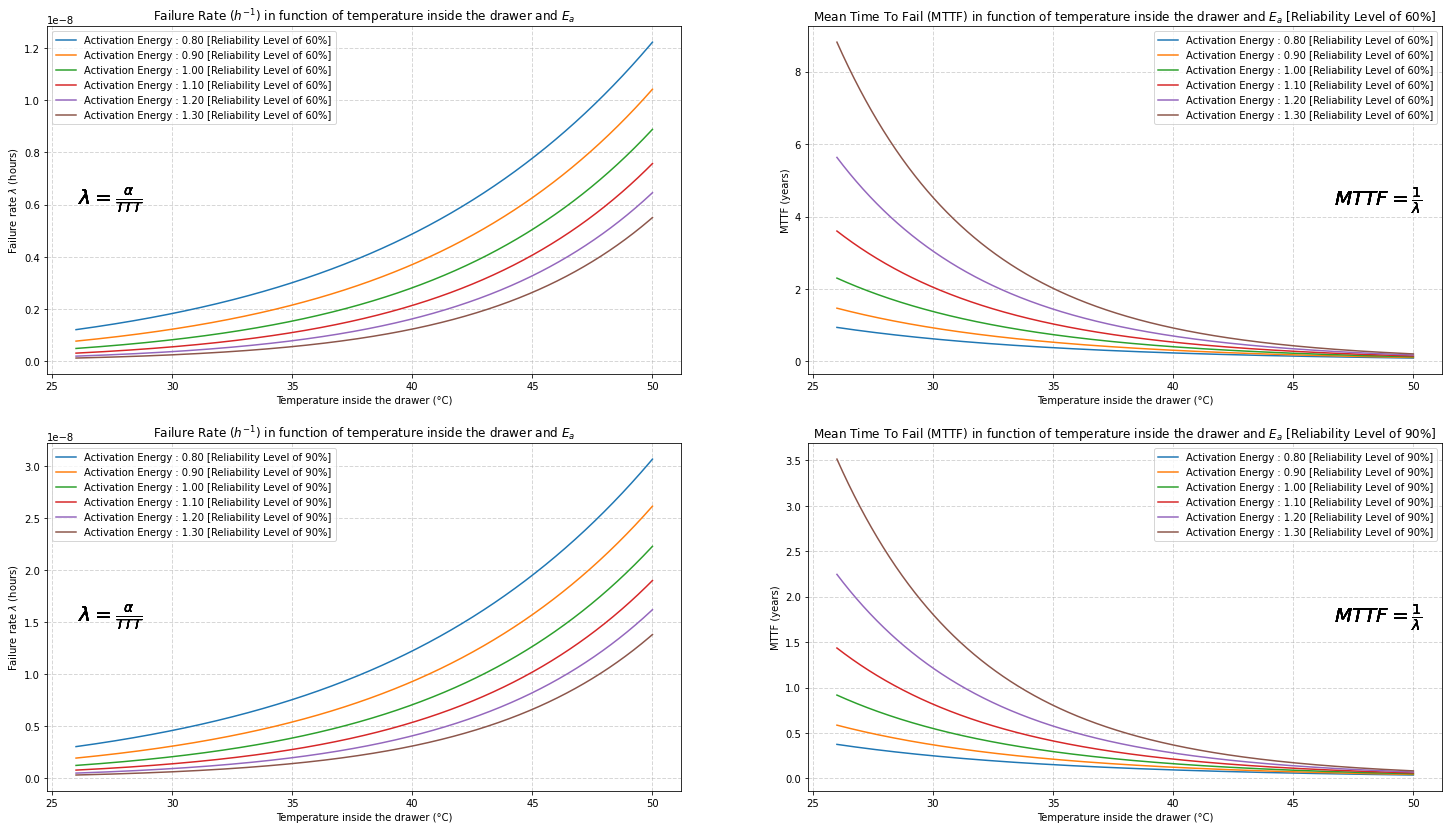

In [15]:
import scipy.constants as const
import numpy as np
import matplotlib.pyplot as plt

T1 = np.linspace(26 + 273,50 + 273 ,1000)
T2 = np.array([65 + 273 for i in range(0,len(T1))])

kb_JperK = const.k
kb_eVperK = kb_JperK / const.elementary_charge

E_a = np.linspace(0.8,1.3,6)

plt.subplots(figsize=(15,8.43))
for E in E_a:
    A_T = np.exp((E / kb_eVperK) * ((1 / T1) - (1 / T2)))
    plt.plot(T1-273,A_T,label=f'Activation Energy : {E:.2f}')
    plt.legend()
    plt.grid(visible=True, linestyle='--', linewidth=1, alpha=0.5)
    plt.title('Temperature acceleration coefficient in function of temperature inside the drawer and Activation Energy')
    plt.ylabel('Temperature acceleration coefficient $A_T$')
    plt.xlabel('Temperature inside the drawer (°C)')
plt.text(0.5, 0.8, '$A_T = exp(\\frac{E_a}{k}(\\frac{1}{T_{SD}} - \\frac{1}{T_{BIT}}))$',ha='center', va='center', transform=plt.gca().transAxes,fontsize=20)

plt.subplots(figsize=(15,8.43))
A_F = {}
for E in E_a:
    A_T = np.exp((E / kb_eVperK) * ((1 / T1) - (1 / T2)))
    A_F[E] = np.array([0 for i in range(0,len(A_T))])
    for id in FENICS12_LTT.id.unique() :
        A_F[E] = A_F[E] + FENICS12_LTT[FENICS12_LTT.id==id].burnTime.max()*A_T
        
    plt.plot(T1-273,A_F[E],label=f'Activation Energy : {E:.2f}')
    plt.legend()
    plt.grid(visible=True, linestyle='--', linewidth=1, alpha=0.5)
    plt.title('Total test time in function of temperature inside the drawer and Activation Energy')
    plt.ylabel('Total test time (Component Hours)')
    plt.xlabel('Temperature inside the drawer (°C)')
    plt.text(0.5, 0.8, '$TTT= \\sum_{id=1}^{id=N} t_n \\times A_F$',ha='center', va='center', transform=plt.gca().transAxes,fontsize=20)

realiability_levels = {
    '60%' : 0.917,
    '90%' : 2.30,
}
Lambda = {}
mttf={}
plt.figure(figsize=(25,14.0625))
for subplot,reliability in enumerate(realiability_levels):
    for E in E_a:
        plt.subplot(2,2,subplot*2+1)
        Lambda[E] = realiability_levels[reliability]/A_F[E]
        mttf[E] = 1/ (Lambda[E] * 1000)
        plt.plot(T1-273, Lambda[E] / 100, label=f'Activation Energy : {E:.2f} [Reliability Level of '+reliability+']')
        plt.ylabel('Failure rate $\lambda$ (hours)')
        plt.xlabel('Temperature inside the drawer (°C)')
        plt.text(0.1, 0.5, '$\\lambda = \\frac{\\alpha}{TTT}$',ha='center', va='center', transform=plt.gca().transAxes,fontsize=20)
        plt.legend(loc='upper left')
        plt.title('Failure Rate ($h^{-1}$) in function of temperature inside the drawer and $E_a$')
        plt.grid(visible=True, linestyle='--', linewidth=1, alpha=0.5)
        
        plt.subplot(2,2,subplot*2+2)
        plt.plot(T1-273, mttf[E]/8750, label=f'Activation Energy : {E:.2f} [Reliability Level of '+reliability+']')
        plt.ylabel('MTTF (years)')
        plt.xlabel('Temperature inside the drawer (°C)')
        plt.text(0.9, 0.5, '$MTTF = \\frac{1}{\\lambda}$',ha='center', va='center', transform=plt.gca().transAxes,fontsize=20)
        plt.legend()
        plt.title('Mean Time To Fail (MTTF) in function of temperature inside the drawer and $E_a$ [Reliability Level of '+reliability+']')
        plt.grid(visible=True, linestyle='--', linewidth=1, alpha=0.5)
plt.savefig('failure_rate_and_MTTF.svg')


In [16]:
import numpy as np
from scipy.stats import weibull_min


def estimation_fail(mttf_years,lambda_per_hour):
    mttf_years = mttf_years
    lambda_per_hour = lambda_per_hour

    failures = np.array([15, 50, 13,40,18,60,55,30,19,40,10])

# Estimate the Weibull parameters using MLE
    params = weibull_min.fit(failures, loc=0)

# Extract the shape parameter (C) from the estimated parameters
    c = params[0]
# Convert mttf to hours
    mttf_hours = mttf_years * 8760

# Estimate shape parameter using MLE
# c = 1.5  # Replace with actual value estimated from data

# Define time period of interest
    time_period_years = 20
    time_period_hours = time_period_years * 8760

# Calculate failure probability over time period
    prob_failure = 1 - np.exp(-(time_period_hours / mttf_hours) ** c * lambda_per_hour * time_period_hours)

# Calculate expected number of failures over time period
    num_failures = prob_failure * 9800
    print(f'C parameter fit = {c}')
    print(f'MTTF = {mttf_years}')
    print(f'Lambda = {lambda_per_hour}')
    print("Probability of failure over {} years: {:.2f}%".format(time_period_years, prob_failure * 100))
    print("Expected number of failures over {} years: {:.2f}".format(time_period_years, num_failures))
    return prob_failure * 100,num_failures

proba,fails = estimation_fail(mttf[0.8][0]/8760,Lambda[0.8][0])


C parameter fit = 0.25074673689418303
MTTF = 0.3739918675524421
Lambda = 3.052345814058252e-07
Probability of failure over 20 years: 13.50%
Expected number of failures over 20 years: 1323.16


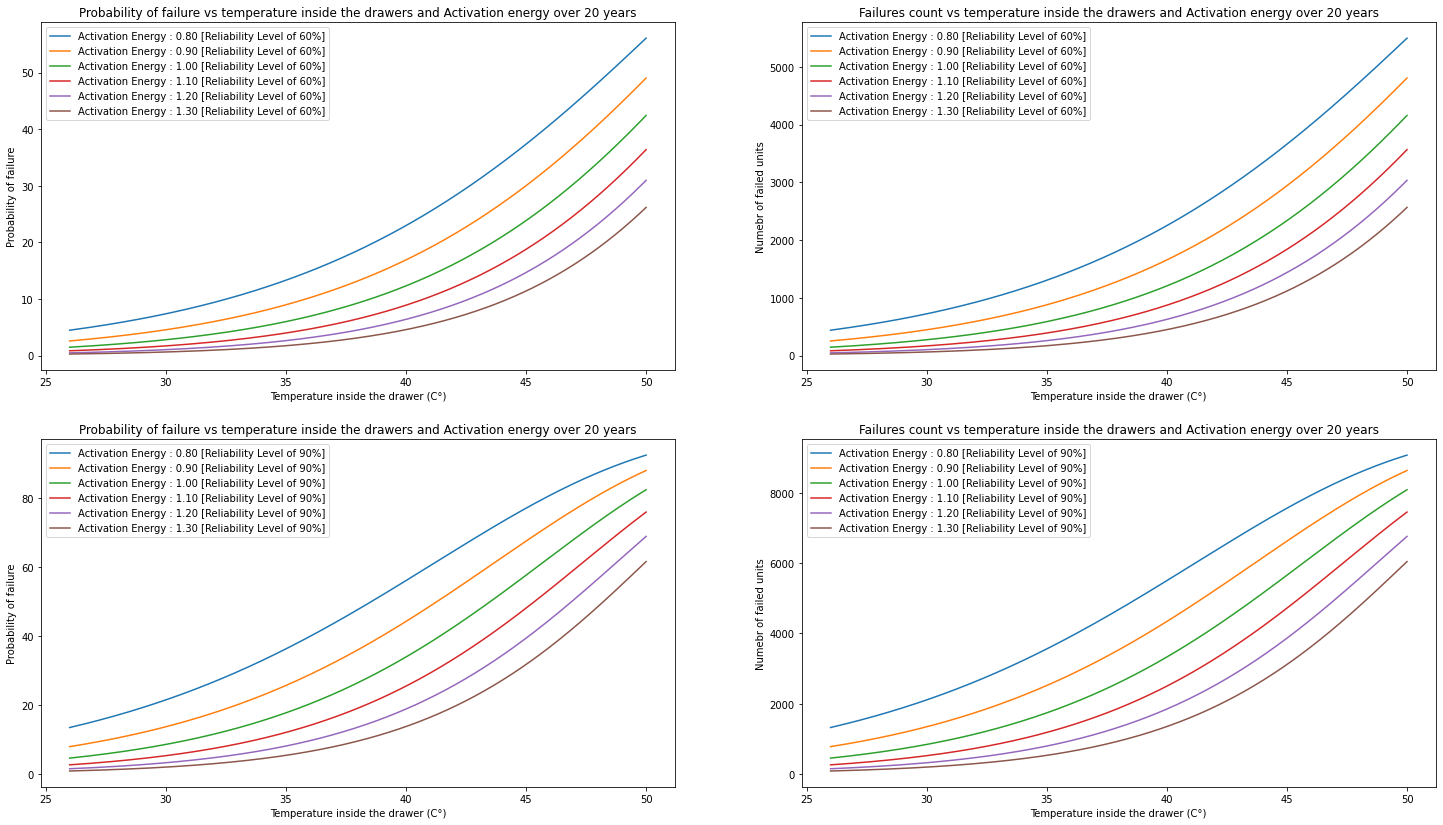

In [17]:


def estimation_fail(mttf_years_array, lambda_per_hour_array,total_years,total_boards,C=1.5):
    failures = C
    params = weibull_min.fit(failures, loc=0)
    c = params[0]

    mttf_hours_array = mttf_years_array * 8760
    time_period_years = total_years
    time_period_hours = time_period_years * 8760

    prob_failure = 1 - np.exp(-(time_period_hours / mttf_hours_array) ** c * lambda_per_hour_array * time_period_hours)
    num_failures = prob_failure * total_boards

    return prob_failure * 100, num_failures



failures = np.array([15, 20, 13, 40, 18, 20, 30, 10, 12, 11, 10])
years = 20
unit_count = 9800

Lambda = {}
mttf={}
plt.figure(figsize=(25,14.0625))
for subplot,reliability in enumerate(realiability_levels):
    for E in E_a:
        plt.subplot(2,2,subplot*2+1)
        Lambda[E] = realiability_levels[reliability]/A_F[E]
        mttf[E] = 1/ (Lambda[E] * 1000)
        proba, fails = estimation_fail(mttf[E] / 8760, Lambda[E],years,unit_count,C=failures)
        plt.plot(T1-273, proba,label=f'Activation Energy : {E:.2f} [Reliability Level of '+reliability+']')
        plt.legend()
        plt.xlabel('Temperature inside the drawer (C°)')
        plt.ylabel('Probability of failure')
        plt.title(f'Probability of failure vs temperature inside the drawers and Activation energy over {years} years')
        
        plt.subplot(2,2,subplot*2+2)
        proba, fails = estimation_fail(mttf[E] / 8760, Lambda[E],years,unit_count,C=failures)
        plt.plot(T1-273, fails,label=f'Activation Energy : {E:.2f} [Reliability Level of '+reliability+']')

        plt.legend()
        plt.xlabel('Temperature inside the drawer (C°)')
        plt.ylabel('Number of failed units')
        plt.title(f'Failures count vs temperature inside the drawers and Activation energy over {years} years')
    
plt.show()